# Imports

In [1]:
import os
import re
import json
import muspy
import pickle
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [2]:
SAVE_GENRE_VECTORS = False

In [3]:
with open('ids_to_genres.json', 'r') as f:
    ids_to_genres = json.load(f)

# Analysis

## Genre analysis

In [4]:
num_found_genres = len([song_id for song_id in ids_to_genres if ids_to_genres[song_id]])
print(f"The matching algorithm has retrieved {num_found_genres} songs with (at least) an attached genre.")

The matching algorithm has retrieved 36334 songs with (at least) an attached genre.


Create a matching genre -> number of instances of that genre.

In [5]:
genres = {}

for song_id in ids_to_genres:
    genres_for_song = ids_to_genres[song_id]
    for genre in genres_for_song:
        if genre in genres:
            genres[genre] += 1
        else:
            genres[genre] = 1

In [6]:
num_unique_genres    = len(genres)
max_songs_per_genre  = max([int(x) for x in genres.values()])
most_frequent_genre  = max(genres.keys(), key=lambda x: genres[x])
min_songs_per_genre  = min([int(x) for x in genres.values()])
num_of_min_songs     = sum([1 for x in genres.values() if x == min_songs_per_genre])
mean_songs_per_genre = np.average([int(x) for x in genres.values()])
std_songs_per_genre  = np.std([int(x) for x in genres.values()])

print(f"There are {num_unique_genres} distinct genres in the dataset.")
print(f"Each genre has an average of {mean_songs_per_genre:.4f} songs, with a standard "
      f"deviation of {std_songs_per_genre:.3f}.")
print(f"The genre which is assigned to the highest number of songs ({max_songs_per_genre}) "
      f"is {most_frequent_genre}, while the minimum is {min_songs_per_genre}.")
print(f"Some examples of the {num_of_min_songs} genres matched to only {min_songs_per_genre} songs: "
      f"{random.choices([g for g in genres.keys() if genres[g] == min_songs_per_genre], k=5)}.")



There are 2146 distinct genres in the dataset.
Each genre has an average of 64.3448 songs, with a standard deviation of 267.226.
The genre which is assigned to the highest number of songs (4860) is rock, while the minimum is 1.
Some examples of the 317 genres matched to only 1 songs: ['musica juiz-forana', 'vintage chanson', 'avant-garde jazz', 'early music ensemble', 'essex indie'].


In [7]:
most_frequent_ordered_genre_names = sorted(
    [genre_name for genre_name in genres], 
    key=lambda g: -genres[g]
)

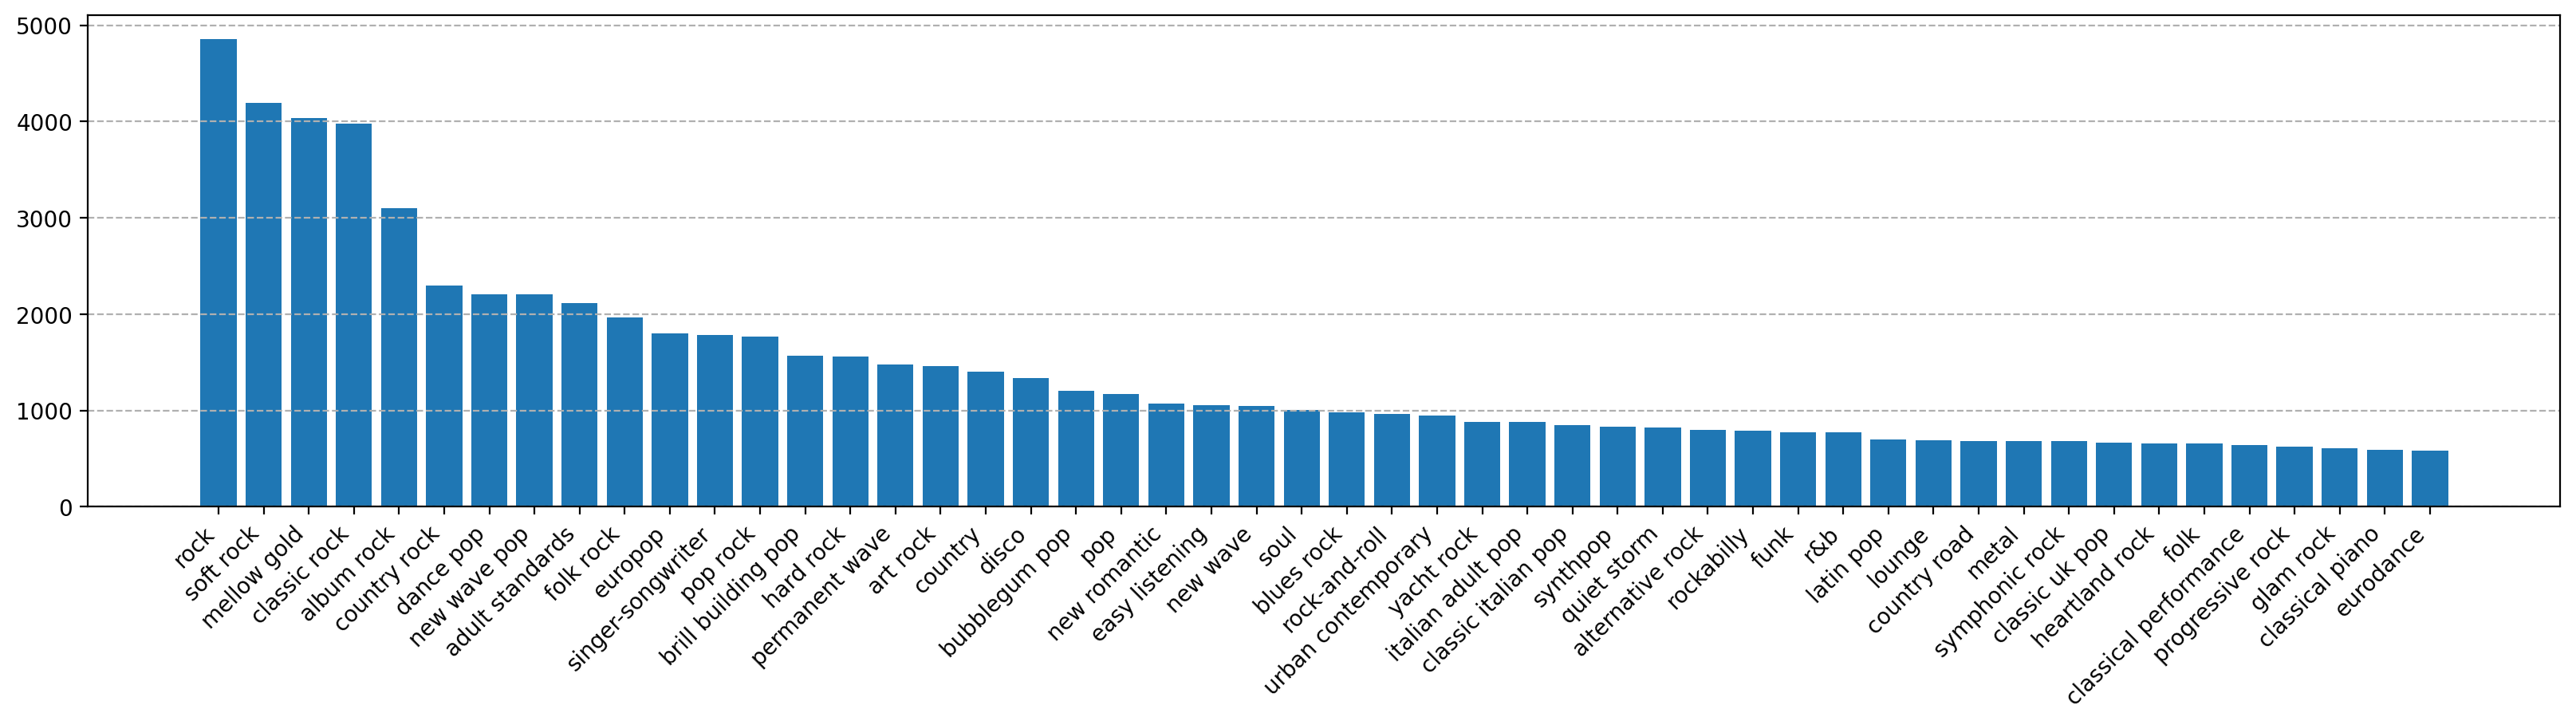

In [8]:
TOP_N = 50
fig, ax = plt.subplots(figsize=(20,4))
plt.bar(most_frequent_ordered_genre_names[:TOP_N], 
        [genres[g] for g in most_frequent_ordered_genre_names[:TOP_N]])
plt.xticks(rotation=45, ha='right');
plt.grid(axis='y', linestyle='--')

## Subgenre analysis

What if we group together some genres composed by multiple words?

In [9]:
grouped_genres = {}

for song_id in ids_to_genres:
    genres_for_song = ids_to_genres[song_id]
    subgenres = set()
    for genre in genres_for_song:
        subgenres = subgenres.union(re.split(r"-| |,", genre))
    for subgenre in subgenres:
        if subgenre in grouped_genres:
            grouped_genres[subgenre] += 1
        else:
            grouped_genres[subgenre] = 1

In [10]:
num_unique_grouped_genres    = len(grouped_genres)
max_songs_per_grouped_genre  = max([int(x) for x in grouped_genres.values()])
most_frequent_grouped_genre  = max(grouped_genres.keys(), key=lambda x: grouped_genres[x])
min_songs_per_grouped_genre  = min([int(x) for x in grouped_genres.values()])
num_of_grouped_min_songs     = sum([1 for x in grouped_genres.values() if x == min_songs_per_genre])
mean_songs_per_grouped_genre = np.average([int(x) for x in grouped_genres.values()])
std_songs_per_grouped_genre  = np.std([int(x) for x in grouped_genres.values()])

print(f"There are {num_unique_grouped_genres} distinct subgenres in the dataset.")
print(f"Each subgenre has an average of {mean_songs_per_grouped_genre:.4f} songs, with a standard "
      f"deviation of {std_songs_per_grouped_genre:.3f}.")
print(f"The subgenre which is assigned to the highest number of songs ({max_songs_per_grouped_genre}) "
      f"is {most_frequent_grouped_genre}, while the minimum is {min_songs_per_grouped_genre}.")
print(f"Some examples of the {num_of_grouped_min_songs} subgenres matched to only {min_songs_per_grouped_genre} songs: "
      f"{random.choices([g for g in grouped_genres.keys() if grouped_genres[g] == min_songs_per_grouped_genre], k=5)}.")



There are 1234 distinct subgenres in the dataset.
Each subgenre has an average of 158.7293 songs, with a standard deviation of 729.964.
The subgenre which is assigned to the highest number of songs (14633) is rock, while the minimum is 1.
Some examples of the 147 subgenres matched to only 1 songs: ['jazzy', 'bassline', 'marimba', 'mississippi', 'modular'].


In [11]:
most_frequent_ordered_grouped_genre_names = sorted(
    [genre_name for genre_name in grouped_genres], 
    key=lambda g: -grouped_genres[g]
)

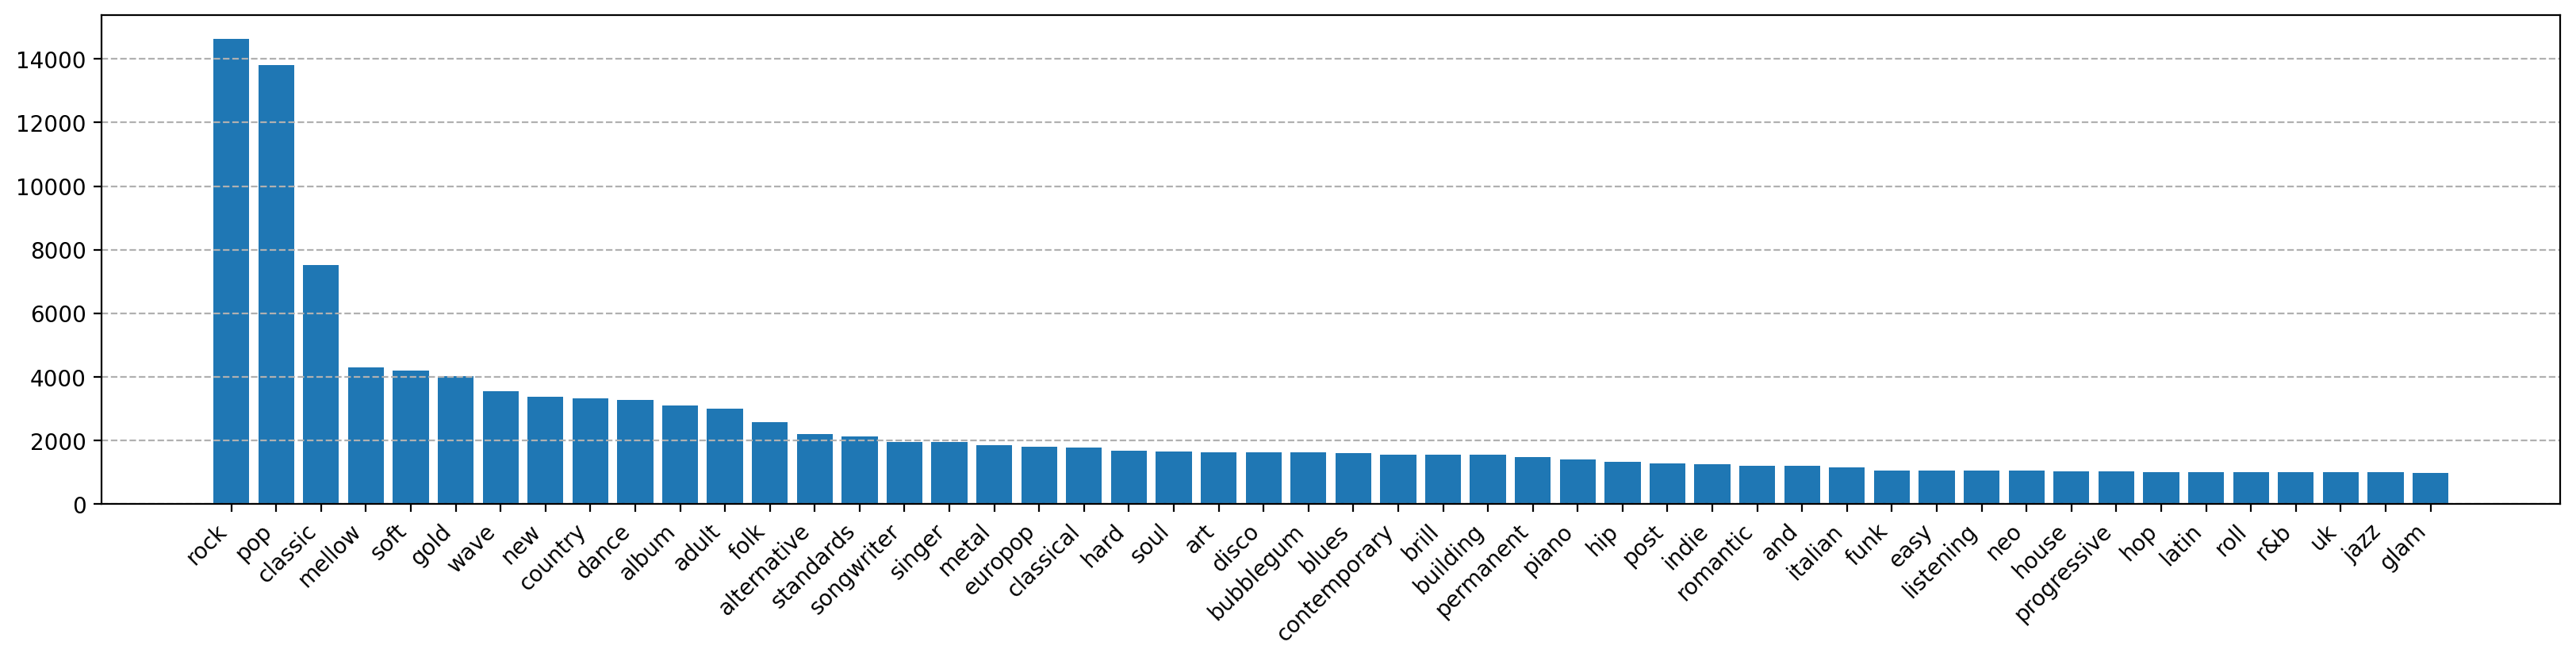

In [12]:
TOP_N = 50
fig, ax = plt.subplots(figsize=(20,4))
plt.bar(most_frequent_ordered_grouped_genre_names[:TOP_N], 
        [grouped_genres[g] for g in most_frequent_ordered_grouped_genre_names[:TOP_N]])
plt.xticks(rotation=45, ha='right');
plt.grid(axis='y', linestyle='--')

There are some interesting subgenres in the top-100 of this new list, like:
- rock
- pop
- dance
- country
- metal
- classical
- folk
- blues
- house
- indie
- latin
- jazz
- funk
- rap
- punk
- r&b
- gospel
- electronic

## Genre assignment

### Genre vocabulary definition

We can check how many songs can be represented using these genres

In [13]:
proposed_genre_list = ["rock","pop","dance","country","metal",
                       "classical","folk","blues","house","indie",
                       "latin","jazz","funk","rap","punk","r&b",
                       "gospel","electronic"]

In [14]:
ids_to_genre_vectors = {}

for song_id in ids_to_genres:
    genres_for_song = ids_to_genres[song_id]
    subgenres = set()
    for genre in genres_for_song:
        subgenres = subgenres.union(re.split(r"-| |,", genre))
    genre_vector = np.array([
        int(proposed_genre_list[i] in subgenres)
        for i in range(len(proposed_genre_list))
    ])
    if np.sum(genre_vector):
        norm_genre_vector = genre_vector / np.sum(genre_vector)
        ids_to_genre_vectors[song_id] = norm_genre_vector

In [15]:
print(f"With a restricted set of sub-genres defined above, there are {len(ids_to_genre_vectors)} "
      f"songs that still have at least a genre among the {num_found_genres} available ones.")


With a restricted set of sub-genres defined above, there are 29144 songs that still have at least a genre among the 36334 available ones.


### Vocabulary refinement

Are there some unused genres among the most frequent ones that would be worth adding to the list?

In [16]:
subgenres_for_song = {}
counts_for_frequent_subgenres = {}

for song_id in ids_to_genres:
    genres_for_song = ids_to_genres[song_id]
    subgenres = set()
    for genre in genres_for_song:
        subgenres = subgenres.union(re.split(r"-| |,", genre))
    subgenres_for_song[song_id] = subgenres

for subgenre_name in most_frequent_ordered_grouped_genre_names[:200]:
    if subgenre_name not in set(proposed_genre_list):
        count_for_subgenre = 0
        for song_id in subgenres_for_song:
            if subgenre_name in subgenres_for_song[song_id] and \
                not any([x in proposed_genre_list for x in subgenres_for_song[song_id]]):
                count_for_subgenre += 1
        counts_for_frequent_subgenres[subgenre_name] = count_for_subgenre

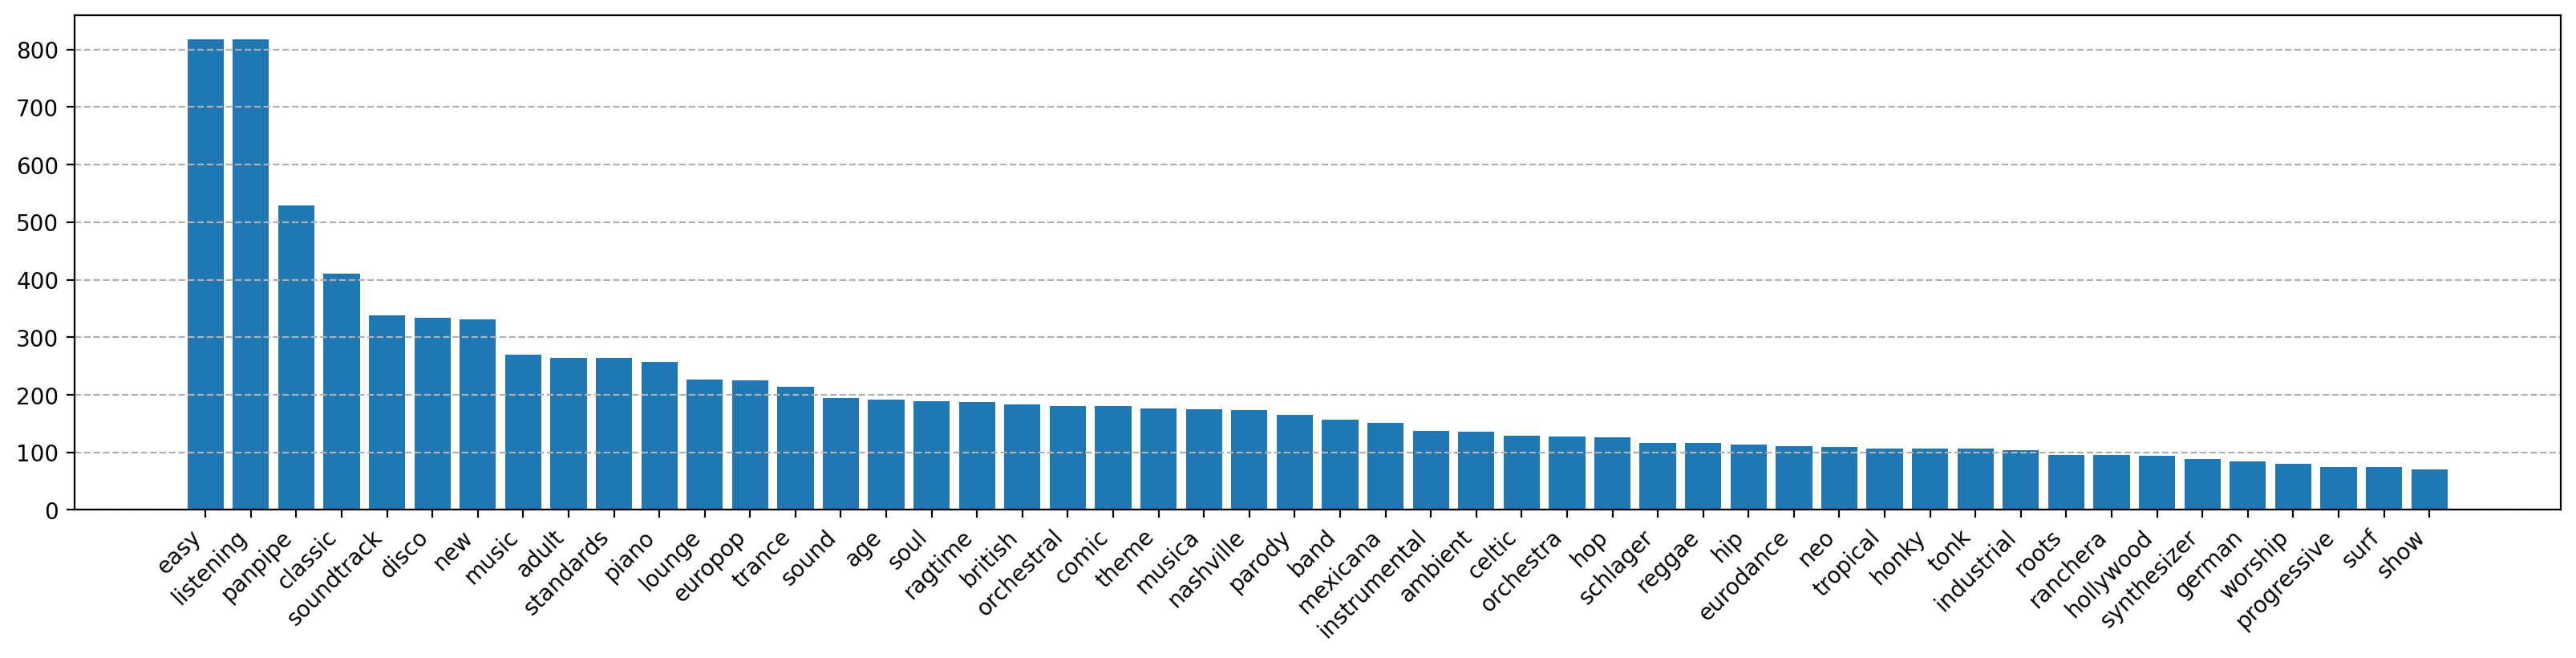

In [17]:
most_useful_subgenres_to_add = sorted(
    [genre_name for genre_name in counts_for_frequent_subgenres], 
    key=lambda g: -counts_for_frequent_subgenres[g]
)

fig, ax = plt.subplots(figsize=(20,4))
plt.bar(most_useful_subgenres_to_add[:TOP_N], 
        [counts_for_frequent_subgenres[g] for g in most_useful_subgenres_to_add[:TOP_N]])
plt.xticks(rotation=45, ha='right');
plt.grid(axis='y', linestyle='--')

We could add the genres "easy listening" and maybe "panpipe" to our vocabulary, sinc ethey would add a good number of new songs, but we chose not to to make the genre mapping simpler.

### Mapping

We will use the Muspy library to map Muspy objects to their genres

In [18]:
def get_genre_vector_for_song(song):
    song_id = song.metadata.source_filename[:-4]
    if song_id in ids_to_genre_vectors:
        return ids_to_genre_vectors[song_id]
    else:
        return None

In [ ]:
if SAVE_GENRE_VECTORS:
    load_dotenv()
    dataset_root_path = Path(os.environ['DATASET_ROOT_PATH'])
    lakh_matched_dataset = muspy.LakhMIDIMatchedDataset(dataset_root_path, use_converted=True)
    list_of_genre_vectors = [get_genre_vector_for_song(song) for song in tqdm(lakh_matched_dataset)]
    with open('lakh_matched_genre_vectors.pickle', 'wb') as f:
        pickle.dump(list_of_genre_vectors, f)